Generate plots based on parametric dataset (compare 4 methods - two full signal and two trial-based):
* % of failed estimates (failed estimation and negative R-squared)
* ACF decline in specific range
* CI: 0 in the interval, width?
* R-squared (on unit level and as %)

Inclusion criteria:
* non zero bins
* 1 hz of activity
* R-squared > 0.5

In [1]:
import numpy as np
import pandas as pd
import pickle
import random

import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
from cfg_global import project_folder_path
os.chdir(current_wd)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LinearSegmentedColormap

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
dataset_folder = project_folder_path + 'results\\synthetic\\dataset\\fig2_3_4a\\'
results_folder = project_folder_path + 'results\\synthetic\\results\\param_fr_alpha_tau\\'

fig_folder = project_folder_path + 'results\\synthetic\\fig_drafts_paper\\inclusion\\'

In [3]:
save_fig = False

### Load data

In [4]:
with open(dataset_folder + '1_spike_trains_3params_var_len600sec_100000.pkl','rb') as f:
    data = pickle.load(f)

spike_trains = data['spike_trains']
alphas = data['alphas']
fr_values = data['fr_values']
taus_ms = data['tau_ms']
duration_ms = data['duration_ms']

print(f'n spike trains {len(spike_trains)}, len {spike_trains[0][-1]/1000}, duration_ms {duration_ms}')

n spike trains 100000, len 598.8243581617338, duration_ms 600000


In [5]:
with open(results_folder + 'acf_isttc_full_50ms_20lags_dict.pkl', "rb") as f:
    isttc_full_dict = pickle.load(f)

with open(results_folder + 'acf_full_50ms_20lags_dict.pkl', "rb") as f:
    acf_full_dict = pickle.load(f)

with open(results_folder + 'pearsonr_trial_avg_50ms_dict.pkl', "rb") as f:
    pearsonr_trial_avg_dict = pickle.load(f)

with open(results_folder + 'sttc_trial_concat_50ms_dict.pkl', "rb") as f:
    sttc_trial_concat_dict = pickle.load(f)

print(f'len isttc_full_dict {len(isttc_full_dict)}')
print(f'len acf_full_dict {len(acf_full_dict)}')
print(f'len pearsonr_trial_avg_dict {len(pearsonr_trial_avg_dict)}')
print(f'len sttc_trial_concat_dict {len(sttc_trial_concat_dict)}')

len isttc_full_dict 100000
len acf_full_dict 100000
len pearsonr_trial_avg_dict 100000
len sttc_trial_concat_dict 100000


### Make summary dfs

In [6]:
def calculate_acf_decline_flag(acf_, start_idx=1, end_idx=4):
    acf_decay = np.all(np.diff(acf_[start_idx:end_idx]) <= 0)
    return acf_decay

def get_trials_plot_df(trial_dict_, method_, alphas_, fr_values_, taus_ms_, n_iteration_=None):
    records = []
    for unit_id, data in trial_dict_.items():
        taus = data['taus']
        acfs = data['acf']

        if n_iteration_ is not None:
            # only one trial per unit
            idx = n_iteration_[unit_id]
            taus_to_iter = [(taus[idx], acfs[idx])]
        else:
            # all trials for this unit
            taus_to_iter = zip(taus, acfs)

        for tau_dict, acf_array in taus_to_iter:
            records.append({
                'unit_id': unit_id,
                'tau': tau_dict['tau'],
                'tau_lower': tau_dict['tau_lower'],
                'tau_upper': tau_dict['tau_upper'],
                'fit_r_squared': tau_dict['fit_r_squared'],
                'acf_decline': calculate_acf_decline_flag(acf_array, start_idx=1, end_idx=4),
                'method': method_,
            })

    df = pd.DataFrame.from_records(records)
    df['tau_ms'] = df['tau'] * 50

    df['fr'] = fr_values_
    df['alpha'] = alphas_
    df['tau_ms_true'] = taus_ms_
    df['tau_diff_abs'] = np.abs(df['tau_ms'] - df['tau_ms_true'])
    df['tau_diff_rel'] = df['tau_diff_abs'] / df['tau_ms_true'] * 100

    nan_count = df.isna().any(axis=1).sum()
    if nan_count > 0:
        print(f'N rows with NaNs {nan_count}, method {method_}')

    return df

def get_full_plot_df(trial_dict_, method_, alphas_, fr_values_, taus_ms_):
    data = []
    for unit_id, unit_data in trial_dict_.items():
        taus = unit_data['taus']  
        data.append({
            'unit_id': unit_id,
            'tau': taus['tau'],
            'tau_lower': taus['tau_lower'],
            'tau_upper': taus['tau_upper'],
            'fit_r_squared': taus['fit_r_squared'],
            'acf_decline': calculate_acf_decline_flag(unit_data['acf'], start_idx=1, end_idx=4),
            'method': method_,
        })
    df = pd.DataFrame(data)
    df['tau_ms'] = df['tau'] * 50
    
    df['fr'] = fr_values_
    df['alpha'] = alphas_
    df['tau_ms_true'] = taus_ms_
    df['tau_diff_abs'] = np.abs(df['tau_ms'] - df['tau_ms_true'])
    df['tau_diff_rel'] = df['tau_diff_abs'] / df['tau_ms_true'] * 100

    nan_count = df.isna().any(axis=1).sum()
    if nan_count > 0:
        print(f'N rows with NaNs {nan_count}, method {method_}')

    return df

In [7]:
# for trial based measures one realization of trials is taken
random_trials_impl = np.zeros(len(sttc_trial_concat_dict)).astype(int)

pearsontr_trial_plot_df = get_trials_plot_df(pearsonr_trial_avg_dict, 'pearsonr_trial_avg', alphas, fr_values, taus_ms, random_trials_impl)
isttc_trial_plot_df = get_trials_plot_df(sttc_trial_concat_dict, 'sttc_trial_concat', alphas, fr_values, taus_ms, random_trials_impl)
isttc_full_plot_df = get_full_plot_df(isttc_full_dict, 'isttc_full', alphas, fr_values, taus_ms)
acf_full_plot_df = get_full_plot_df(acf_full_dict, 'acf_full', alphas, fr_values, taus_ms)

N rows with NaNs 12393, method pearsonr_trial_avg
N rows with NaNs 11, method acf_full


In [8]:
tau_plot_all_long_df = pd.concat([acf_full_plot_df, 
                                  isttc_full_plot_df, 
                                  pearsontr_trial_plot_df, 
                                  isttc_trial_plot_df])
tau_plot_all_long_df.reset_index(inplace=True, drop=True)

tau_plot_all_long_df['ci_zero_excluded'] = (
    (tau_plot_all_long_df['tau_lower'] > 0) | (tau_plot_all_long_df['tau_upper'] < 0)
).astype(int)

tau_plot_all_long_df['ci_width'] = np.where(
    tau_plot_all_long_df['ci_zero_excluded'] == 1,
    tau_plot_all_long_df['tau_upper'] - tau_plot_all_long_df['tau_lower'],
    np.nan
)

tau_plot_all_long_df['ci_width_ms'] = tau_plot_all_long_df['ci_width'] * 50

print(f'len tau_plot_long_df {len(tau_plot_all_long_df)}')
print(tau_plot_all_long_df.keys())
tau_plot_all_long_df.head(3)

len tau_plot_long_df 400000
Index(['unit_id', 'tau', 'tau_lower', 'tau_upper', 'fit_r_squared',
       'acf_decline', 'method', 'tau_ms', 'fr', 'alpha', 'tau_ms_true',
       'tau_diff_abs', 'tau_diff_rel', 'ci_zero_excluded', 'ci_width',
       'ci_width_ms'],
      dtype='object')


,unit_id,tau,tau_lower,tau_upper,fit_r_squared,acf_decline,method,tau_ms,fr,alpha,tau_ms_true,tau_diff_abs,tau_diff_rel,ci_zero_excluded,ci_width,ci_width_ms
0,0,2.217899,2.119224,2.316575,0.998369,True,acf_full,110.894975,7.741821,0.851099,150.923515,40.028540,26.522401,1,0.197350,9.867517
1,1,2.568210,2.437150,2.699270,0.997899,True,acf_full,128.410512,4.394396,0.858098,147.947233,19.536721,13.205195,1,0.262120,13.105996
2,2,5.227451,4.334421,6.120482,0.984960,True,acf_full,261.372568,8.587393,0.528805,267.002290,5.629722,2.108492,1,1.786061,89.303030


### Plot overlall stats (without within unit comparison)

In [9]:
color_acf_full = '#718190'
color_isttc_full = '#1ba9e2'
color_pearson_trail_avg = '#f4a91c' 
color_sttc_trail_concat = '#955da2' 

colors = [color_acf_full, color_isttc_full, color_pearson_trail_avg, color_sttc_trail_concat]
color_trails = ['black', color_pearson_trail_avg, color_sttc_trail_concat] # black is when both method failed

#### % of failed estimates (failed estimation and negative R-squared)

In [10]:
def compute_exclusion(group):
    tau_nans = group['tau'].isna().sum()
    fit_r_squared_neg = (group['fit_r_squared'] < 0).sum()
    either_issue = ((group['tau'].isna()) | (group['fit_r_squared'] < 0)).sum()
    total = len(group)
    percent_tau_nans = 100 * tau_nans / total if total > 0 else 0
    percent_fit_r_squared_neg = 100 * fit_r_squared_neg / total if total > 0 else 0
    percent_either_issue = 100 * either_issue / total if total > 0 else 0
    return pd.Series({
        'tau_nans': tau_nans,
        'fit_r_squared_neg': fit_r_squared_neg,
        'exclusion': either_issue,
        'percent_tau_nans': percent_tau_nans,
        'percent_fit_r_squared_neg': percent_fit_r_squared_neg,
        'exclusion_perc': percent_either_issue
    })

exclusion_df = tau_plot_all_long_df.groupby('method').apply(compute_exclusion).reset_index()
exclusion_df

C:\Users\ipochino\AppData\Local\Temp\ipykernel_9096\3609447145.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  exclusion_df = tau_plot_all_long_df.groupby('method').apply(compute_exclusion).reset_index()


,method,tau_nans,fit_r_squared_neg,exclusion,percent_tau_nans,percent_fit_r_squared_neg,exclusion_perc
0,acf_full,11.0,237.0,248.0,0.011,0.237,0.248
1,isttc_full,0.0,238.0,238.0,0.000,0.238,0.238
2,pearsonr_trial_avg,12393.0,4201.0,16594.0,12.393,4.201,16.594
3,sttc_trial_concat,0.0,6268.0,6268.0,0.000,6.268,6.268


In [11]:
exclusion_df.sum()

method                       acf_fullisttc_fullpearsonr_trial_avgsttc_trial...
tau_nans                                                               12404.0
fit_r_squared_neg                                                      10944.0
exclusion                                                              23348.0
percent_tau_nans                                                        12.404
percent_fit_r_squared_neg                                               10.944
exclusion_perc                                                          23.348
dtype: object

In [ ]:
diff_trial_methods = exclusion_df.query('method == "pearsonr_trial_avg"')['exclusion'].values[0] - exclusion_df.query('method == "sttc_trial_concat"')['exclusion'].values[0]
diff_trial_methods

In [ ]:
diff_trial_methods = exclusion_df.set_index('method').loc['pearsonr_trial_avg', 'exclusion'] - \
                     exclusion_df.set_index('method').loc['sttc_trial_concat', 'exclusion']
diff_trial_methods_perc = exclusion_df.set_index('method').loc['pearsonr_trial_avg', 'exclusion_perc'] - \
                     exclusion_df.set_index('method').loc['sttc_trial_concat', 'exclusion_perc']
print(f'diff_trial_methods {diff_trial_methods}, diff_trial_methods_perc {diff_trial_methods_perc}')

In [ ]:
methods = exclusion_df['method']
x = np.arange(len(methods))

fig, axes = plt.subplots(1,1, figsize=(5,3))

axes.bar(x, exclusion_df['percent_tau_nans'], label='Failed fit')
axes.bar(x, exclusion_df['percent_fit_r_squared_neg'], bottom=exclusion_df['percent_tau_nans'], label='Negative R-squared')
axes.set_xticks(x, methods, rotation=45)
axes.set_ylabel('Percentage of units (%)')
axes.set_title(f'Excluded fits, diff % {diff_trial_methods_perc}, diff units {diff_trial_methods}')
axes.legend(frameon = False)
axes.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
axes.set_yticks([0,5,10,15,20])

total = exclusion_df['exclusion_perc']
for i, (xi, height) in enumerate(zip(x, total)):
    axes.text(xi, height + 0.3, f"{height:.2f}%", ha='center', va='bottom', fontsize=9)

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'excluded_fits_plot.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'excluded_fits_plot.svg' , bbox_inches='tight')

In [12]:
nans_neg_r2_df = tau_plot_all_long_df.query('tau.isna() or fit_r_squared < 0')[['unit_id', 'method', 'fr', 'alpha', 'tau_ms_true']].copy()
print(nans_neg_r2_df.keys())
nans_neg_r2_df

Index(['unit_id', 'method', 'fr', 'alpha', 'tau_ms_true'], dtype='object')


,unit_id,method,fr,alpha,tau_ms_true
997,997,acf_full,0.033065,0.695408,210.248651
1553,1553,acf_full,3.699036,0.148351,280.805644
1836,1836,acf_full,0.015676,0.730262,126.916556
1910,1910,acf_full,0.120057,0.890543,65.975195
2495,2495,acf_full,5.226193,0.165966,249.009988
...,...,...,...,...,...
399952,99952,sttc_trial_concat,5.869952,0.335180,289.960242
399973,99973,sttc_trial_concat,0.143518,0.722081,228.791545
399983,99983,sttc_trial_concat,6.698488,0.262788,212.846140
399984,99984,sttc_trial_concat,0.039075,0.210591,243.583679


##### For which units methods fail? (in general)

nans_neg_r2_df without duplicates

In [ ]:
nans_neg_r2_df_unique_df = nans_neg_r2_df.drop_duplicates(subset='unit_id')
nans_neg_r2_df_unique_df = nans_neg_r2_df_unique_df.drop_duplicates(subset='unit_id').reset_index(drop=True)

method_counts = nans_neg_r2_df.groupby('unit_id').size().rename('n_methods')
nans_neg_r2_df_unique_df = nans_neg_r2_df_unique_df.merge(method_counts, on='unit_id')
nans_neg_r2_df_unique_df

In [ ]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """
    Return a new colormap based on cmap but only sampling its colors
    between minval and maxval (both in [0,1]).
    """
    new_colors = cmap(np.linspace(minval, maxval, n))
    new_cmap = LinearSegmentedColormap.from_list(
        f"{cmap.name}_trunc_{minval:.2f}_{maxval:.2f}",
        new_colors
    )
    return new_cmap

trunc_magma = truncate_colormap(plt.cm.magma, minval=0.1, maxval=1)

fig, axes = plt.subplots(1,2, figsize=(8,2.5))

#norm = TwoSlopeNorm(vcenter=0)

hb0 = axes[0].hexbin(
    x=nans_neg_r2_df_unique_df['fr'], y=nans_neg_r2_df_unique_df['alpha'],
    gridsize=10,                
    cmap=trunc_magma           
)

hb1 = axes[1].hexbin(
    x=nans_neg_r2_df_unique_df['tau_ms_true'], y=nans_neg_r2_df_unique_df['alpha'],
    gridsize=10,                
    cmap=trunc_magma               
)

axes[0].set_xlabel('Firing rate (hz)')
axes[1].set_xlabel('Intrinsic timescale (ms)')
axes[1].set_xticks(np.linspace(50, 300, 6))

vmin = np.min([hb0.get_array().min(), hb1.get_array().min()])
vmax = np.max([hb0.get_array().max(), hb1.get_array().max()])
print(vmin, vmax)

hb0.set_clim(vmin, vmax)
hb1.set_clim(vmin, vmax)

fig.colorbar(hb0, ax=axes[0], shrink=1)
fig.colorbar(hb1, ax=axes[1], shrink=1)

fig.suptitle(f'Excluded fits', y=1.05)

for ax in axes.flat:
    sns.despine(ax=ax)
    ax.set_ylabel('Excitation strength (a.u.)')
    ax.set_ylim([0.1, 0.9])
    ax.set_yticks(np.linspace(0.1, 0.9, 5))

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'excluded_fits_vs_3params.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'excluded_fits_vs_3params.svg' , bbox_inches='tight')

In [ ]:
# # same as before but as a histplot
# fig, axes = plt.subplots(1,2, figsize=(8,4))

# sns.histplot(ax=axes[0], x=nans_neg_r2_df_unique_df['fr'].values, y=nans_neg_r2_df_unique_df['alpha'].values, bins=50)
# sns.histplot(ax=axes[1], x=nans_neg_r2_df_unique_df['tau_ms_true'].values, y=nans_neg_r2_df_unique_df['alpha'].values, bins=50)

# sns.despine()

##### For which units methods fail? (methods specific)

nans_neg_r2_df 

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(8,3))

sns.scatterplot(ax=axes[0], x='fr', y='alpha', hue='method', data=nans_neg_r2_df, s=5, alpha=0.5, palette=colors, legend=False)
sns.scatterplot(ax=axes[1], x='tau_ms_true', y='alpha', hue='method', data=nans_neg_r2_df, s=5, alpha=0.5, palette=colors, legend=True)

axes[0].set_xlabel('Firing rate (hz)')
axes[1].set_xlabel('Intrinsic timescale (ms)')
axes[1].set_xticks(np.linspace(50, 300, 6))

axes[1].legend(bbox_to_anchor=(0.95, 1.25), ncol=4, frameon=False, markerscale=6)

for ax in axes.flat:
    ax.set_ylabel('Excitation strength (a.u.)')
    ax.set_ylim([0.1, 0.9])
    ax.set_yticks(np.linspace(0.1, 0.9, 5))

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'excluded_fits_vs_3params_per_method_scatter.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'excluded_fits_vs_3params_per_method_scatter.svg' , bbox_inches='tight')

In [ ]:
fig, axes = plt.subplots(4,2, figsize=(6,10), sharey=True, sharex=False)

sns.scatterplot(ax=axes[0,0], x='fr', y='alpha', data=nans_neg_r2_df_unique_df.query('n_methods == 4'), s=5, alpha=1, legend=False)
sns.scatterplot(ax=axes[0,1], x='tau_ms_true', y='alpha', data=nans_neg_r2_df_unique_df.query('n_methods == 4'), s=5, alpha=1,legend=True)

sns.scatterplot(ax=axes[1,0], x='fr', y='alpha', data=nans_neg_r2_df_unique_df.query('n_methods == 3'), s=5, alpha=1, legend=False)
sns.scatterplot(ax=axes[1,1], x='tau_ms_true', y='alpha', data=nans_neg_r2_df_unique_df.query('n_methods == 3'), s=5, alpha=1,legend=True)

sns.scatterplot(ax=axes[2,0], x='fr', y='alpha', data=nans_neg_r2_df_unique_df.query('n_methods == 2'), s=5, alpha=1, legend=False)
sns.scatterplot(ax=axes[2,1], x='tau_ms_true', y='alpha', data=nans_neg_r2_df_unique_df.query('n_methods == 2'), s=5, alpha=1,legend=True)

sns.scatterplot(ax=axes[3,0], x='fr', y='alpha', data=nans_neg_r2_df_unique_df.query('n_methods == 1'), s=5, alpha=1, legend=False)
sns.scatterplot(ax=axes[3,1], x='tau_ms_true', y='alpha', data=nans_neg_r2_df_unique_df.query('n_methods == 1'), s=5, alpha=1,legend=True)

axes[0,0].set_title('4 methods failed')
axes[1,0].set_title('3 methods failed')
axes[2,0].set_title('2 methods failed')
axes[3,0].set_title('1 methods failed')

for ax in axes.flat:
    ax.set_ylabel('Excitation strength (a.u.)')
    ax.set_ylim([0.1, 0.9])
    ax.set_yticks(np.linspace(0.1, 0.9, 5))
    ax.set_xlabel('')
    ax.set_xticks([])

axes[3,0].set_xlabel('Firing rate (hz)')
axes[3,1].set_xlabel('Intrinsic timescale (ms)')
axes[3,0].set_xticks(np.linspace(0, 10, 5))
axes[3,1].set_xticks(np.linspace(50, 300, 6))

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'excluded_fits_vs_3params_per_n_methods_scatter.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'excluded_fits_vs_3params_per_n_methods_scatter.svg' , bbox_inches='tight')

In [14]:
nans_neg_r2_df_trials = nans_neg_r2_df[nans_neg_r2_df['method'].isin(['pearsonr_trial_avg', 'sttc_trial_concat'])]
nans_neg_r2_df_trials.reset_index(inplace=True, drop=True)
method_counts = nans_neg_r2_df_trials.groupby('unit_id')['method'].nunique()
both_methods = method_counts[method_counts == 2].index

# Count
num_both = len(both_methods)
print(f"Number of units with both methods: {num_both}")

Number of units with both methods: 4469


In [15]:
method1 = "pearsonr_trial_avg"
method2 = "sttc_trial_concat"

def detect_failed_methods(methods):
    methods_set = set(methods)
    if method1 in methods_set and method2 in methods_set:
        return "both"
    elif method1 in methods_set:
        return method1
    elif method2 in methods_set:
        return method2
    else:
        return "none"  # just in case, this shouldn't happen

failed_methods = nans_neg_r2_df_trials.groupby('unit_id')['method'].apply(detect_failed_methods).rename('failed_methods')
# Take one row per unit_id (e.g., the first), and merge in the failed_methods info
nans_neg_r2_df_trials_unique = nans_neg_r2_df_trials.drop_duplicates(subset='unit_id').merge(failed_methods, on='unit_id')

In [18]:
nans_neg_r2_df_trials_unique.groupby(by='failed_methods', as_index=False).count()

,failed_methods,unit_id,method,fr,alpha,tau_ms_true
0,both,4469,4469,4469,4469,4469
1,pearsonr_trial_avg,12125,12125,12125,12125,12125
2,sttc_trial_concat,1799,1799,1799,1799,1799


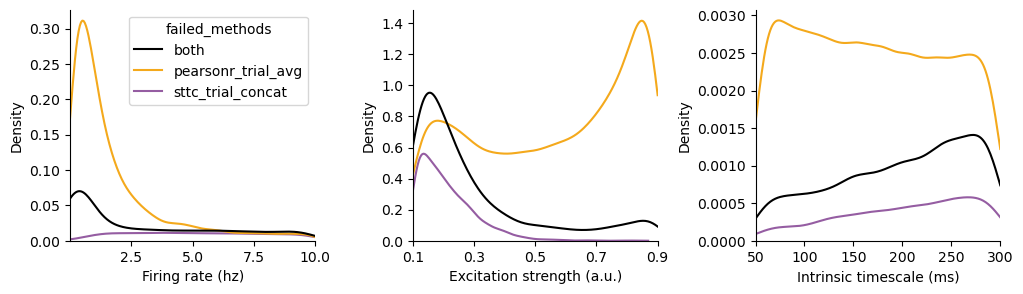

In [16]:
fig, axes = plt.subplots(1,3, figsize=(12,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.kdeplot(
    data=nans_neg_r2_df_trials_unique, 
    x='fr', 
    hue='failed_methods', 
    hue_order=['both', 'pearsonr_trial_avg', 'sttc_trial_concat'],    
    clip=(0, 10),
    common_norm=True,  
    fill=False,
    palette=color_trails,
    legend=True,
    ax=axes[0]
)

sns.kdeplot(
    data=nans_neg_r2_df_trials_unique, 
    x='alpha', 
    hue='failed_methods', 
    hue_order=['both', 'pearsonr_trial_avg', 'sttc_trial_concat'],    
    clip=(0.1, 0.9),
    common_norm=True,  
    fill=False,
    palette=color_trails,
    legend=False,
    ax=axes[1]
)

sns.kdeplot(
    data=nans_neg_r2_df_trials_unique, 
    x='tau_ms_true', 
    hue='failed_methods', 
    hue_order=['both', 'pearsonr_trial_avg', 'sttc_trial_concat'],    
    clip=(50, 300),
    common_norm=True,  
    fill=False,
    palette=color_trails,
    legend=False,
    ax=axes[2]
)

axes[0].set_xlabel('Firing rate (hz)')
axes[1].set_xlabel('Excitation strength (a.u.)')
axes[2].set_xlabel('Intrinsic timescale (ms)')

axes[0].set_xticks(np.linspace(0, 10, 5))
axes[2].set_xticks(np.linspace(50, 300, 6))
axes[1].set_xticks(np.linspace(0.1, 0.9, 5))

axes[0].set_xlim([0.01, 10])
axes[1].set_xlim([0.1, 0.9])
axes[2].set_xlim([50, 300])

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'excluded_fits_vs_3params_per_methods_trial_scatter.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'excluded_fits_vs_3params_per_methods_trial_scatter.svg' , bbox_inches='tight')

In [ ]:
bins = 10
fr_bins = np.linspace(0.01, 10, bins + 1)
alpha_bins = np.linspace(0.1, 0.9, bins + 1)
tau_bins = np.linspace(50, 300, bins + 1)

hist1, _, _ = np.histogram2d(nans_neg_r2_df_trials.query('method == "pearsonr_trial_avg"')['fr'], 
                             nans_neg_r2_df_trials.query('method == "pearsonr_trial_avg"')['alpha'], 
                             bins=[fr_bins, alpha_bins])
hist2, _, _ = np.histogram2d(nans_neg_r2_df_trials.query('method == "sttc_trial_concat"')['fr'], 
                             nans_neg_r2_df_trials.query('method == "sttc_trial_concat"')['alpha'], 
                             bins=[fr_bins, alpha_bins])
hist_diff = hist2 - hist1

hist1_tau, _, _ = np.histogram2d(nans_neg_r2_df_trials.query('method == "pearsonr_trial_avg"')['tau_ms_true'], 
                             nans_neg_r2_df_trials.query('method == "pearsonr_trial_avg"')['alpha'], 
                             bins=[tau_bins, alpha_bins])
hist2_tau, _, _ = np.histogram2d(nans_neg_r2_df_trials.query('method == "sttc_trial_concat"')['tau_ms_true'], 
                             nans_neg_r2_df_trials.query('method == "sttc_trial_concat"')['alpha'], 
                             bins=[tau_bins, alpha_bins])
hist_diff_tau = hist2_tau - hist1_tau

diff_limit = np.max([np.abs(hist_diff.min()), 
                     np.abs(hist_diff.max())])
print(diff_limit)

diff_tau_limit = np.max([np.abs(hist_diff_tau.min()), 
                     np.abs(hist_diff_tau.max())])
print(diff_tau_limit)

plot_limits = np.max([diff_limit, diff_tau_limit])

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

norm = TwoSlopeNorm(vcenter=0, vmin=-plot_limits, vmax=plot_limits)

sns.heatmap(hist_diff.T, ax=axes[0], cmap="RdBu_r", norm=norm, cbar=True)
axes[0].set_title("iSTTC fails - PearsonR fails")
axes[0].invert_yaxis()

sns.heatmap(hist_diff_tau.T, ax=axes[1], cmap="RdBu_r", norm=norm, cbar=True)
axes[1].set_title("iSTTC fails - PearsonR fails")
axes[1].invert_yaxis()

axes[0].set_xlabel('Firing rate (hz)')
axes[0].set_ylabel('Excitation strength (a.u.)')
axes[1].set_xlabel('Intrinsic timescale (ms)')
axes[1].set_ylabel('Excitation strength (a.u.)')

axes[0].set_yticklabels([])
axes[1].set_yticklabels([])
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])


# ind_limit = np.max([np.abs(hist1.min()), np.abs(hist2.min()), np.abs(hist1.max()), np.abs(hist2.max())])
# print(ind_limit)
# sns.heatmap(hist1.T, ax=axes[1], cmap="magma", vmin=0, vmax=ind_limit, cbar=True)
# axes[1].invert_yaxis()

# sns.heatmap(hist2.T, ax=axes[2], cmap="magma", vmin=0, vmax=ind_limit, cbar=True)
# axes[2].invert_yaxis()

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'excluded_fits_vs_3params_per_methods_trial_hist.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'excluded_fits_vs_3params_per_methods_trial_hist.svg' , bbox_inches='tight')

#### ACF decline and CI without zero

In [19]:
included_df = tau_plot_all_long_df.query('tau.notna() and fit_r_squared >= 0').copy()
print(f'len {len(included_df)}')
included_df.groupby(by='method', as_index=False).count()

len 376652


,method,unit_id,tau,tau_lower,tau_upper,fit_r_squared,acf_decline,tau_ms,fr,alpha,tau_ms_true,tau_diff_abs,tau_diff_rel,ci_zero_excluded,ci_width,ci_width_ms
0,acf_full,99752,99752,99752,99752,99752,99752,99752,99752,99752,99752,99752,99752,99752,92695,92695
1,isttc_full,99762,99762,99762,99762,99762,99762,99762,99762,99762,99762,99762,99762,99762,92500,92500
2,pearsonr_trial_avg,83406,83406,83406,83406,83406,83406,83406,83406,83406,83406,83406,83406,83406,30387,30387
3,sttc_trial_concat,93732,93732,93732,93732,93732,93732,93732,93732,93732,93732,93732,93732,93732,38013,38013


In [20]:
acf_decline_df = included_df.groupby('method').agg(
    num_true=('acf_decline', lambda x: x.sum())
).assign(
    total=100000,
    percent_true=lambda x: 100 * x['num_true'] / x['total']
).reset_index()
acf_decline_df

,method,num_true,total,percent_true
0,acf_full,88094,100000,88.094
1,isttc_full,88494,100000,88.494
2,pearsonr_trial_avg,53376,100000,53.376
3,sttc_trial_concat,61431,100000,61.431


In [21]:
acf_decline_df.sum()

method          acf_fullisttc_fullpearsonr_trial_avgsttc_trial...
num_true                                                   291395
total                                                      400000
percent_true                                              291.395
dtype: object

In [ ]:
methods = acf_decline_df['method']
x = np.arange(len(methods))

diff_acf_methods = acf_decline_df.set_index('method').loc['pearsonr_trial_avg', 'num_true'] - \
                     acf_decline_df.set_index('method').loc['sttc_trial_concat', 'num_true']
diff_acf_methods_perc = acf_decline_df.set_index('method').loc['pearsonr_trial_avg', 'percent_true'] - \
                     acf_decline_df.set_index('method').loc['sttc_trial_concat', 'percent_true']
print(f'diff_acf_methods {diff_acf_methods}, diff_acf_methods_perc {diff_acf_methods_perc}')

diff_acf_full_methods = acf_decline_df.set_index('method').loc['acf_full', 'num_true'] - \
                     acf_decline_df.set_index('method').loc['isttc_full', 'num_true']
diff_acf_full_methods_perc = acf_decline_df.set_index('method').loc['acf_full', 'percent_true'] - \
                     acf_decline_df.set_index('method').loc['isttc_full', 'percent_true']

fig, axes = plt.subplots(1,1, figsize=(5,3))

axes.bar(x, acf_decline_df['percent_true'], label='')

axes.set_xticks(x, methods, rotation=45)
axes.set_ylabel('Percentage of units (%)')
axes.set_title(f'ACF decline, \ndiff % {diff_acf_methods_perc}, diff units {diff_acf_methods}, \ndiff % {diff_acf_full_methods_perc:.2f}, diff units {diff_acf_full_methods}')
axes.legend(frameon = False)
axes.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
#axes.set_yticks([0,5,10,15,20])
axes.set_ylim([0, 100])

total = acf_decline_df['percent_true']
for i, (xi, height) in enumerate(zip(x, total)):
    axes.text(xi, height + 0.3, f"{height:.2f}%", ha='center', va='bottom', fontsize=9)

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'acf_decline_plot.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'acf_decline_plot.svg' , bbox_inches='tight')

In [22]:
ci_zero_df = included_df.groupby('method').agg(
    num_true=('ci_zero_excluded', lambda x: x.sum())
).assign(
    total=100000,
    percent_true=lambda x: 100 * x['num_true'] / x['total']
).reset_index()
ci_zero_df

,method,num_true,total,percent_true
0,acf_full,92695,100000,92.695
1,isttc_full,92500,100000,92.500
2,pearsonr_trial_avg,30387,100000,30.387
3,sttc_trial_concat,38013,100000,38.013


In [23]:
ci_zero_df.sum()

method          acf_fullisttc_fullpearsonr_trial_avgsttc_trial...
num_true                                                   253595
total                                                      400000
percent_true                                              253.595
dtype: object

In [ ]:
methods = acf_decline_df['method']
x = np.arange(len(methods))

diff_acf_methods = ci_zero_df.set_index('method').loc['pearsonr_trial_avg', 'num_true'] - \
                     ci_zero_df.set_index('method').loc['sttc_trial_concat', 'num_true']
diff_acf_methods_perc = ci_zero_df.set_index('method').loc['pearsonr_trial_avg', 'percent_true'] - \
                     ci_zero_df.set_index('method').loc['sttc_trial_concat', 'percent_true']
print(f'diff_acf_methods {diff_acf_methods}, diff_acf_methods_perc {diff_acf_methods_perc}')

diff_acf_full_methods = ci_zero_df.set_index('method').loc['acf_full', 'num_true'] - \
                     ci_zero_df.set_index('method').loc['isttc_full', 'num_true']
diff_acf_full_methods_perc = ci_zero_df.set_index('method').loc['acf_full', 'percent_true'] - \
                     ci_zero_df.set_index('method').loc['isttc_full', 'percent_true']

fig, axes = plt.subplots(1,1, figsize=(5,3))

axes.bar(x, ci_zero_df['percent_true'], label='')

axes.set_xticks(x, methods, rotation=45)
axes.set_ylabel('Percentage of units (%)')
axes.set_title(f'CI without 0, \ndiff % {diff_acf_methods_perc:.2f}, diff units {diff_acf_methods}, \ndiff % {diff_acf_full_methods_perc:.2f}, diff units {diff_acf_full_methods}')
axes.legend(frameon = False)
axes.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
#axes.set_yticks([0,5,10,15,20])
axes.set_ylim([0, 100])

total = ci_zero_df['percent_true']
for i, (xi, height) in enumerate(zip(x, total)):
    axes.text(xi, height + 0.3, f"{height:.2f}%", ha='center', va='bottom', fontsize=9)

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'ci_no_zero_plot.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'ci_no_zero_plot.svg' , bbox_inches='tight')

#### R-squared > 0.5

In [24]:
fit_r2_df = included_df.groupby('method').agg(
    num_true=('fit_r_squared', lambda x: (x >= 0.5).sum())
).assign(
    total=100000,
    percent_true=lambda x: 100 * x['num_true'] / x['total']
).reset_index()
fit_r2_df

,method,num_true,total,percent_true
0,acf_full,96294,100000,96.294
1,isttc_full,96128,100000,96.128
2,pearsonr_trial_avg,43915,100000,43.915
3,sttc_trial_concat,51630,100000,51.630


In [25]:
fit_r2_df.sum()

method          acf_fullisttc_fullpearsonr_trial_avgsttc_trial...
num_true                                                   287967
total                                                      400000
percent_true                                              287.967
dtype: object

In [ ]:
methods = acf_decline_df['method']
x = np.arange(len(methods))

diff_acf_methods = fit_r2_df.set_index('method').loc['pearsonr_trial_avg', 'num_true'] - \
                     fit_r2_df.set_index('method').loc['sttc_trial_concat', 'num_true']
diff_acf_methods_perc = fit_r2_df.set_index('method').loc['pearsonr_trial_avg', 'percent_true'] - \
                     fit_r2_df.set_index('method').loc['sttc_trial_concat', 'percent_true']
print(f'diff_acf_methods {diff_acf_methods}, diff_acf_methods_perc {diff_acf_methods_perc}')

diff_acf_full_methods = fit_r2_df.set_index('method').loc['acf_full', 'num_true'] - \
                     fit_r2_df.set_index('method').loc['isttc_full', 'num_true']
diff_acf_full_methods_perc = fit_r2_df.set_index('method').loc['acf_full', 'percent_true'] - \
                     fit_r2_df.set_index('method').loc['isttc_full', 'percent_true']

fig, axes = plt.subplots(1,1, figsize=(5,3))

axes.bar(x, fit_r2_df['percent_true'], label='')

axes.set_xticks(x, methods, rotation=45)
axes.set_ylabel('Percentage of units (%)')
axes.set_title(f'R2 >= 0.5, \ndiff % {diff_acf_methods_perc:.2f}, diff units {diff_acf_methods}, \ndiff % {diff_acf_full_methods_perc:.2f}, diff units {diff_acf_full_methods}')
axes.legend(frameon = False)
axes.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
#axes.set_yticks([0,5,10,15,20])
axes.set_ylim([0, 100])

total = fit_r2_df['percent_true']
for i, (xi, height) in enumerate(zip(x, total)):
    axes.text(xi, height + 0.3, f"{height:.2f}%", ha='center', va='bottom', fontsize=9)

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'r2_more_0_5_plot.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'r2_more_0_5_plot.svg' , bbox_inches='tight')

In [ ]:
included_df.head(2)

#colors = [color_acf_full, color_isttc_full, color_pearson_trail_avg, color_sttc_trail_concat]

In [ ]:
# R2 as KDE plots

fig, axes = plt.subplots(1,3, figsize=(15,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.kdeplot(
    data=included_df, 
    x='fit_r_squared', 
    hue='method', 
    hue_order=['acf_full', 'isttc_full', 'pearsonr_trial_avg', 'sttc_trial_concat'],    
    clip=(0, 1),
    common_norm=True,  
    fill=False,
    palette=colors,
    legend=True,
    ax=axes[0]
)

sns.kdeplot(
    data=included_df.query('method == "acf_full" or method == "isttc_full"'), 
    x='fit_r_squared', 
    hue='method', 
    hue_order=['acf_full', 'isttc_full'],    
    clip=(0, 1),
    common_norm=True,  
    fill=False,
    palette=[color_acf_full, color_isttc_full],
    legend=True,
    ax=axes[1]
)

sns.kdeplot(
    data=included_df.query('method == "pearsonr_trial_avg" or method == "sttc_trial_concat"'), 
    x='fit_r_squared', 
    hue='method', 
    hue_order=['pearsonr_trial_avg', 'sttc_trial_concat'],    
    clip=(0, 1),
    common_norm=True,  
    fill=False,
    palette=[color_pearson_trail_avg, color_sttc_trail_concat],
    legend=True,
    ax=axes[2]
)

for ax in axes.flat:
    ax.axvline(x=0.5, lw=0.5, c='k')
    ax.set_xlim([0,1])
    ax.set_xticks(np.linspace(0, 1, 5))

sns.despine()

save_fig=True

if save_fig:
    plt.savefig(fig_folder + 'r2_kde_plot.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'r2_kde_plot.svg' , bbox_inches='tight')

In [ ]:
included_df_subset = included_df[['unit_id', 'fit_r_squared', 'method']].copy()
included_df_subset


In [ ]:
# intervals for error plots
intervals = {
    '0.75-1':   (0.75,   1),
    '0.5-1':  (0.5,  1),
    '0.25-1':  (0.25,  1)
}


df = included_df_subset.copy()
rows = []
for method, sub in df.groupby(by=['method']):
    #total = len(sub)
    total = 100000
    row = {'method': method}
    for name, (lo, hi) in intervals.items():
        cnt = sub['fit_r_squared'].between(lo, hi).sum()
        row[name] = cnt/total*100
    rows.append(row)
tau_3methods_error_df = pd.DataFrame(rows).set_index('method')

# make long df
tau_3methods_error_df = tau_3methods_error_df.reset_index()
tau_3methods_error_long_df = tau_3methods_error_df.melt(
    id_vars='method',
    var_name='interval',
    value_name='percentage'
)

tau_3methods_error_long_df[['method',]] = pd.DataFrame(
    tau_3methods_error_long_df['method'].tolist(),
    index=tau_3methods_error_long_df.index
)
tau_3methods_error_long_df = tau_3methods_error_long_df.rename(columns={'interval':'interval'})
tau_3methods_error_long_df = tau_3methods_error_long_df[['method','interval','percentage']]
tau_3methods_error_long_df

In [ ]:
def plot_one_threshold(axes_, percent_long_df):
    axes_.plot(
    percent_long_df.query('method == "pearsonr_trial_avg"')['interval'],
    percent_long_df.query('method == "pearsonr_trial_avg"')['percentage'],
    color=color_pearson_trail_avg, marker='o', markersize=5, linewidth=0.5, label='pearsonr_avg' 
    )
    # axes_.plot(
    # percent_long_df.query('method == "sttc_trial_avg"')['interval'],
    # percent_long_df.query('method == "sttc_trial_avg"')['percentage'],
    # color=color_sttc_trail_avg, marker='o', markersize=5, linewidth=0.5, label='sttc_avg' 
    # )
    axes_.plot(
    percent_long_df.query('method == "sttc_trial_concat"')['interval'],
    percent_long_df.query('method == "sttc_trial_concat"')['percentage'],
    color=color_sttc_trail_concat, marker='o', markersize=5, linewidth=0.5, label='sttc_concat' 
    )
    axes_.plot(
    percent_long_df.query('method == "acf_full"')['interval'],
    percent_long_df.query('method == "acf_full"')['percentage'],
    color=color_acf_full, marker='o', markersize=5, linewidth=0.5, label='acf_full' 
    )
    axes_.plot(
    percent_long_df.query('method == "isttc_full"')['interval'],
    percent_long_df.query('method == "isttc_full"')['percentage'],
    color=color_isttc_full, marker='o', markersize=5, linewidth=0.5, label='isttc_full' 
    )

def plot_one_threshold_jittered_lines(ax, df, jitter=0.15, seed=None, plot_lines=False):
    if seed is not None:
        np.random.seed(seed)

    methods = [
        ("pearsonr_trial_avg", color_pearson_trail_avg, "pearsonr_avg"),
        # ("sttc_trial_avg",     color_sttc_trail_avg,     "sttc_avg"),
        ("sttc_trial_concat",  color_sttc_trail_concat,  "sttc_concat"),
        ("acf_full",           color_acf_full,           "acf_full"),
        ("isttc_full",         color_isttc_full,         "isttc_full"),
    ]

    # fixed ordering of intervals
    cats = list(df["interval"].unique())
    idx_map = {cat:i for i,cat in enumerate(cats)}

    for method, col, label in methods:
        sub = df[df["method"] == method]
        # map string-labels to integer indices
        x0 = np.array([idx_map[s] for s in sub["interval"]])
        y  = sub["percentage"].values

        #  one jitter per point
        offsets = np.random.uniform(-jitter, jitter, size=len(x0))
        xj = x0 + offsets

        if plot_lines:
            order = np.argsort(x0)
            ax.plot(xj[order], y[order],
                    color=col,
                    linewidth=0.8,
                    alpha=1)
        # plot jittered points
        ax.scatter(xj, y,
                   color=col,
                   s=40,
                   marker="o",
                   label=label)

    ax.set_xticks(np.arange(len(cats)))
    ax.set_xticklabels(cats)

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(12,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

plot_one_threshold(axes[0], tau_3methods_error_long_df)

plot_one_threshold_jittered_lines(axes[1],
    tau_3methods_error_long_df,
    jitter=0.3, seed=42)

plot_one_threshold_jittered_lines(axes[2],
    tau_3methods_error_long_df,
    jitter=0.2, seed=42, plot_lines=True)

for ax in axes.flat:
    ax.set_ylabel('Percentage of \nspike trains')
    ax.set_xlabel('R-squared (a.u)')
    ax.set_ylim([0, 105])
    ax.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
    sns.despine(ax=ax)
    
axes[0].legend(frameon=False)


if save_fig:
    plt.savefig(fig_folder + 'r_squared_intervals.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'r_squared_intervals.svg' , bbox_inches='tight')

#### REE vs R-squared 

In [ ]:
included_df['tau_diff_rel_log10'] = np.log10(included_df['tau_diff_rel'])
included_df

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(12, 3))

sns.violinplot(y='tau_diff_rel_log10', x='acf_decline',  data=included_df , cut=0, density_norm='width', ax=axes[0])
sns.violinplot(y='tau_diff_rel_log10', x='ci_zero_excluded',  data=included_df , cut=0, density_norm='width', ax=axes[1])

sns.regplot(y=included_df['tau_diff_rel_log10'].values, x=included_df['fit_r_squared'].values, scatter=None, ax=axes[2])
axes[2].set_yticks([1, 2, 3])
axes[2].set_yticklabels([10, 100, 1000])
axes[2].set_ylabel('REE')
axes[2].set_xlabel('R-squared')

sns.despine()

# if save_fig:
#     plt.savefig(fig_folder + 'ree_vs_3params.png' , bbox_inches='tight', dpi=300)
#     plt.savefig(fig_folder + 'ree_vs_3params.svg' , bbox_inches='tight')

In [ ]:
included_df_no_zeros = included_df.query('fit_r_squared > 0').copy()
included_df_no_zeros['fit_r_squared_log10'] = np.log10(included_df_no_zeros['fit_r_squared'])

fig, axes = plt.subplots(1,3, figsize=(12, 3))

sns.violinplot(y='tau_diff_rel_log10', x='acf_decline',  data=included_df_no_zeros , cut=0, density_norm='width', ax=axes[0])
sns.violinplot(y='tau_diff_rel_log10', x='ci_zero_excluded',  data=included_df_no_zeros , cut=0, density_norm='width', ax=axes[1])

sns.regplot(y=included_df_no_zeros['tau_diff_rel_log10'].values, x=included_df_no_zeros['fit_r_squared_log10'].values, scatter=None, ax=axes[2])
axes[2].set_yticks([1, 2, 3])
axes[2].set_yticklabels([10, 100, 1000])
axes[2].set_ylabel('REE')
axes[2].set_xlabel('R-squared')

sns.despine()

# if save_fig:
#     plt.savefig(fig_folder + 'ree_vs_3params_r2_above0.png' , bbox_inches='tight', dpi=300)
#     plt.savefig(fig_folder + 'ree_vs_3params_r2_above0.svg' , bbox_inches='tight')

In [ ]:
included_df_no_zeros['fit_r_squared_log10'].describe()

'### Export for stats

In [ ]:
df_no_nan = tau_plot_all_long_df.dropna(subset=['tau'])
df_no_nan = df_no_nan[df_no_nan['fit_r_squared'] >= 0]
# how many methods each unit_id has after dropping NaNs
method_counts = df_no_nan.groupby('unit_id')['method'].nunique()

valid_units = method_counts[method_counts == 4].index
filtered_df = tau_plot_all_long_df[tau_plot_all_long_df['unit_id'].isin(valid_units)]
filtered_df.reset_index(inplace=True, drop=True)

In [ ]:
filtered_df

In [ ]:
filtered_df.to_csv(results_folder + 'tau_plot_all_long_not_nan_df.csv')

In [ ]:
filtered_df.groupby(by='method', as_index=False).count()

In [ ]:
print(f'len {len(included_df)}')
included_df.to_csv(results_folder + 'tau_4methods_long_all_not_nan_r2_not_neg_df.csv')